## Importo il dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
df = pd.read_csv('./../datasets/dataset_for_ML.csv')
X = pd.get_dummies(df.drop(['result'], axis=1))
y = df['result'].apply(lambda x: 2 if x == 'victory' else 1 if x == 'draw' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

### Matrice di Correlazione

C:\Users\dario\AppData\Local\Temp\ipykernel_2140\3322700413.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


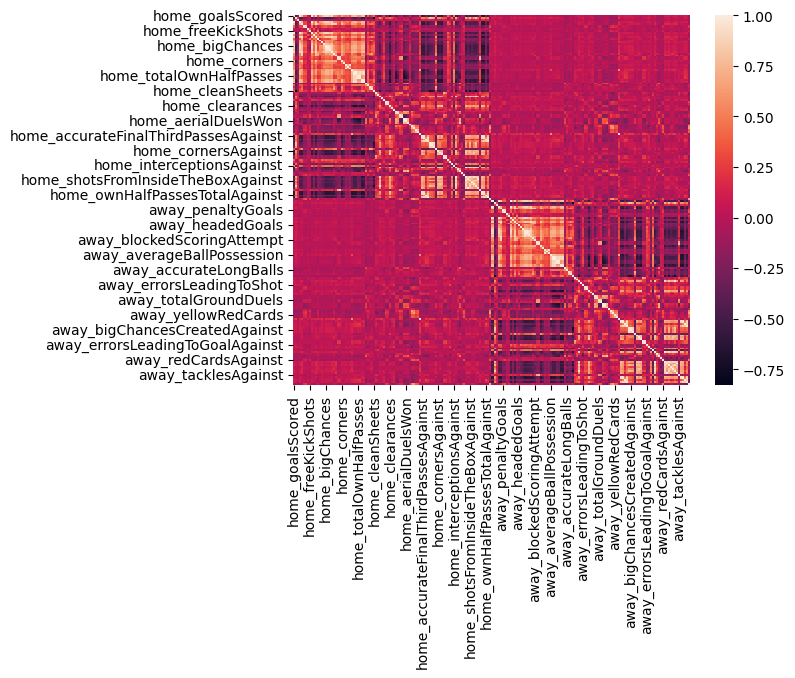

In [3]:
import seaborn as sn
import matplotlib.pyplot as plt

corr_matrix = df.corr()
sn.heatmap(corr_matrix)
plt.show()

## Neural Network

In [ ]:
import tqdm
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical

function_to_test = [ chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression ]
results = []

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

with open('outNN_k.txt', 'w') as f_out:
	for func in function_to_test:
		print(func)
		for k in tqdm.tqdm(range(5, 199, 2)):
			selector = SelectKBest(func, k=k)
			X_new = selector.fit_transform(X_train, y_train)

			# get the column name
			cols = selector.get_support(indices=True)

			# Get columns to keep and create new dataframe with those only for the train example
			X_new = X_train.iloc[:,cols]
			X_test_modified = X_test.iloc[:,cols]

			y_train_modified = to_categorical(y_train)
			y_test_modified = to_categorical(y_test)

			# create model
			model = Sequential()
			model.add(Dense(50, input_dim=k, activation='relu', kernel_initializer='he_uniform'))
			model.add(Dense(3, activation='softmax'))
			adam = Adam(learning_rate=0.001)
			# Compile model
			model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

			model.fit(X_new, y_train_modified, epochs=200, batch_size=80, verbose=0)
			results.append(model.evaluate(X_test_modified, y_test_modified, verbose=0))
			f_out.write(f'{results[-1]}\n')


Dopo aver effettuato la selezione dei k best, questa è la tabella relativa alle funzioni usate per la selezione e il k che ha avuto la maggiore accuratezza:
| Function	               | Best K-Features  | Accuracy |    
| -------------------------|------------------|----------|    
| chi2	                   | 165	          | 0.5212   |
| f_regression	           | 155	          | 0.5287   |
| f_classif	               | 83	              | 0.5212   |
| mutual_info_classif	   | 55	              | 0.5362   |
| mutual_info_regression   | 169	          | 0.5337   |


In [ ]:
import tqdm
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical

function_to_test = [ chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression ]
results = []

def create_model(neurons):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_dim=17, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
	return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)
model = KerasClassifier(model=create_model, verbose=0)
hyperparams = {
    'batch_size': [40, 80],
    'epochs': [100, 200],
    'optimizer__learning_rate': [0.001, 0.01, 0.15],
    'optimizer__momentum': [0.0, 0.4, 0.8],
    'model__neurons': [50, 100, 150, 200],
}
print('starting grid search')
grid = GridSearchCV(estimator=model, param_grid=hyperparams, n_jobs=-1, cv=10, verbose=3)
selector = SelectKBest(mutual_info_classif, k=55)
X_new = selector.fit_transform(X_train, y_train)

# get the column name
cols = selector.get_support(indices=True)

# Get columns to keep and create new dataframe with those only for the test example
X_new_train = X_train.iloc[:,cols]
X_new_test = X_test.iloc[:,cols]

y_test_cat = to_categorical(y_test)
y_train_cat = to_categorical(y_train)

grid_result = grid.fit(X_new, y_train, validation_data=(X_new_test, y_test_cat))

# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

La GridSearch ha trovato come miglior combinazione:
- batch_size: 80,
- epochs: 200,
- model__neurons: 50,
- optimizer__learning_rate: 0.01,
- optimizer__momentum: 0.8,

Ora mostriamo i grafici relativi ai risultati ottenuti dell'andamento degli iperparametri.
 
La raccolta dei dati dell'andamento viene effettuata tramite gli output della grid search e selectKBest e mettendoli in un file chiamato `output_NN.txt`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math

folds = 10

def clean_line_NN(line: str) -> list:
    trimmed = line.replace('\'', '"')
    accuracy = float(line[:trimmed.find('(') - 1])
    start_index = trimmed.index('{')
    print(trimmed)
    results = list(json.loads(trimmed[start_index:]).values())
    return [*results, accuracy]

with open('output_NN.txt') as f:
    next(f)
    lines = [clean_line_NN(line) for line in f]
    
hyperparams = {
    'batch_size': [40, 80],
    'epochs': [100, 200],
    'model__neurons': [50, 100, 150, 200],
    'optimizer__learning_rate': [0.001, 0.01, 0.15],
    'optimizer__momentum': [0.0, 0.4, 0.8],
}
param_grid_filtered = {
    'batch_size': [40, 80],
    'epochs': [100, 200],
    'optimizer__learning_rate': [0.001, 0.01, 0.15],
}
batch_size_count = 0
epochs_count = 0
optimizer__learning_rate_count = 0
step = len(param_grid_filtered['epochs']) * len(param_grid_filtered['optimizer__learning_rate'])
checkpoint_batch_size_count = [step * (i + 1) for i in range(len(param_grid_filtered['batch_size']))]
step = len(param_grid_filtered['optimizer__learning_rate'])
checkpoint_epochs_count = [step * (i + 1) for i in range(len(param_grid_filtered['epochs'] * len(param_grid_filtered['batch_size'])))]
print(checkpoint_batch_size_count)
print(checkpoint_epochs_count)
# calculating number of combinations
total_comb = math.prod(len(val) for val in param_grid_filtered.values())
for count in range(total_comb):
    # updating the hyperparam counters
    if count in checkpoint_batch_size_count:
        batch_size_count += 1
    if count in checkpoint_epochs_count:
        epochs_count = (epochs_count + 1) % len(param_grid_filtered['epochs'])
    curr_batch_size_count = param_grid_filtered['batch_size'][batch_size_count]
    curr_epochs_count = param_grid_filtered['epochs'][epochs_count]
    curr_optimizer__learning_rate = param_grid_filtered['optimizer__learning_rate'][optimizer__learning_rate_count]
    
    filtered_lines = [[float(line[2]), float(line[4]), float(line[5])] for line in lines if curr_batch_size_count == int(line[0]) and curr_epochs_count == int(line[1]) and curr_optimizer__learning_rate == float(line[3])]
    results = np.array([[line[0], line[1], line[2]] for line in filtered_lines])
    optimizer__learning_rate_count = (optimizer__learning_rate_count + 1) % len(param_grid_filtered['optimizer__learning_rate'])
    x = results[..., 0]
    y = results[..., 1]
    z = results[..., 2]
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
    plt.title(f'Accuracy varying on model__neurons and optimizer__momentum\nbatch_size = {curr_batch_size_count}\nepochs = {curr_epochs_count}\noptimizer__learning_rate = {curr_optimizer__learning_rate}')
    ax.set_xticks(x, [line[0] for line in filtered_lines])
    ax.set_yticks(y, [line[1] for line in filtered_lines])
    ax.set_xlabel('model__neurons')
    ax.set_ylabel('optimizer__momentum')
    ax.set_zlabel('Accuracy')
    plt.show()

I grafici risultanti sono:

<img src="../graphs/Neural%20Network/hyperparameters/batch_size_40__eqochs_100__learning_rate_0.001.png" alt="batch_size_40__eqochs_100__learning_rate_0.001.png" style="height: 500px"/>
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_40__eqochs_100__learning_rate_0.01.png" alt="batch_size_40__eqochs_100__learning_rate_0.01.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_40__eqochs_100__learning_rate_0.15.png" alt="batch_size_40__eqochs_100__learning_rate_0.15.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_40__eqochs_200__learning_rate_0.001.png" alt="batch_size_40__eqochs_200__learning_rate_0.001.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_40__eqochs_200__learning_rate_0.01.png" alt="batch_size_40__eqochs_200__learning_rate_0.01.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_40__eqochs_200__learning_rate_0.15.png" alt="batch_size_40__eqochs_200__learning_rate_0.15.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_80__eqochs_100__learning_rate_0.001.png" alt="batch_size_80__eqochs_100__learning_rate_0.001.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_80__eqochs_100__learning_rate_0.01.png" alt="batch_size_80__eqochs_100__learning_rate_0.01.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_80__eqochs_100__learning_rate_0.15.png" alt="batch_size_80__eqochs_100__learning_rate_0.15.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_80__eqochs_200__learning_rate_0.001.png" alt="batch_size_80__eqochs_200__learning_rate_0.001.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_80__eqochs_200__learning_rate_0.01.png" alt="batch_size_80__eqochs_200__learning_rate_0.01.png" style="height: 500px" />
<img src="../graphs/Neural%20Network/hyperparameters/batch_size_80__eqochs_200__learning_rate_0.15.png" alt="batch_size_80__eqochs_200__learning_rate_0.15.png" style="height: 500px" />

Accuracy relativa all'andamento della selezione del k best al variare delle funzioni e del numero di features

In [ ]:
lines = []
with open('outNN_k.txt') as f:
    lines = [float(data[1:-2].split(',')[1]) for data in f.readlines()]
    
functions = [
    'chi2',
    'f_regression',
    'f_classif',
    'mutual_info_classif',
    'mutual_info_regression',
]

kbest_per_func = np.array(
    [lines[i * 97: (i + 1) * 97] for i in range(5)]
)

nbest_per_func = np.arange(5, 199, 2)

for i, func in enumerate(functions):
    x = nbest_per_func
    y = kbest_per_func[i, ...]

    print(func, np.max(kbest_per_func[i]), (np.argmax(kbest_per_func[i]) * 2 + 5))
    plt.title(f'Accuracy varying on k best features using {func}')
    plt.xlabel('k best features')
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

I grafici risultanti sono:

<img src="../graphs/Neural%20Network/kbest/chi2.png" alt="chi2.png" style="width: 500px" />
<img src="../graphs/Neural%20Network/kbest/f_classif.png" alt="f_classif.png" style="width: 500px" />
<img src="../graphs/Neural%20Network/kbest/f_regression.png" alt="f_regression.png" style="width: 500px" />
<img src="../graphs/Neural%20Network/kbest/mutual_info_classif.png" alt="mutual_info_classif.png" style="width: 500px" />
<img src="../graphs/Neural%20Network/kbest/mutual_info_regression.png" alt="mutual_info_regression.png" style="width: 500px" />

## Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf_base = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=10, n_jobs=-1, verbose=10)
# Fit the grid search to the data
best_model = grid_search.fit(X_train, y_train)
# print best parameter after tuning
print("best params: ", grid_search.best_params_)
# print how our model looks after hyper-parameter tuning
print("best estimator: ", grid_search.best_estimator_)
grid_predictions = grid_search.predict(X_test)
print(classification_report(y_test, grid_predictions))
print('testing selezionando le migliori features')

La GridSearch ha trovato come miglior combinazione:
- bootstrap: True
- max_depth: 80
- max_features: 2
- min_samples_leaf: 5
- min_samples_split: 12
- n_estimators: 100

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.metrics import accuracy_score
import tqdm

function_to_test = [ chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression ]
hyperparams = grid_search.best_params_
results = []
for f in function_to_test:
    print(f.__name__)
    results.append([])
    for i in tqdm.tqdm(range(5, 199)):
        selector = SelectKBest(f, k=i)
        X_new = selector.fit_transform(X_train, y_train)
        # get the column name
        cols = selector.get_support(indices=True)
        # Get columns to keep and create new dataframe with those only for the train example
        X_new = X_train.iloc[:,cols]
        rf_final = RandomForestClassifier(**hyperparams)
        rf_final.fit(X_new, y_train)
        # Get columns to keep and create new dataframe with those only for the test example
        X_test_new = X_test.iloc[:,cols]
        grid_predictions = rf_final.predict(X_test_new)
        # report performance
        results[-1].append(accuracy_score(y_test, grid_predictions))

print(results)

Dopo aver effettuato la selezione dei k best, questa è la tabella relativa alle funzioni usate per la selezione e il k che ha avuto la maggiore accuratezza:
| Function	               | Best K-Features  | Accuracy |    
| -------------------------|------------------|----------|    
| chi2	                   | 175	          | 0.531    |
| f_regression	           | 168	          | 0.528    |
| f_classif	               | 112              | 0.526    |
| mutual_info_classif	   | 47               | 0.526    |
| mutual_info_regression   | 87 	          | 0.538    |

Ora mostriamo i grafici relativi ai risultati ottenuti dell'andamento degli iperparametri.
 
La raccolta dei dati dell'andamento viene effettuata tramite gli output della grid search e selectKBest e mettendoli in un file chiamato `outRandomForest` e `outRandomForestKBest`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def clean_line(line: str) -> list:
    start_index = line.index('END') + 4
    end_index = line.index('total') - 1
    line = line[start_index:end_index].replace(';', '').replace(' ', '')
    return [part.split('=')[1] for part in line.split(',')]

lines = []
with open('outRandomForest') as f:
    lines = f.readlines()

lines = [line for line in lines if 'END' in line and 'CV 10/10' in line]

new_lines = []
# ordering by fold
for line in lines:
    indexFirst = line.index(';')
    indexLast = line.index('/288')
    indexCV = int(line[indexFirst+2:indexLast])
    cleaned_line = clean_line(line)
    new_lines.append((indexCV, cleaned_line))

lines = sorted(new_lines)
lines = [line[1] for line in lines]

param_grid_filtered = {
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}

max_feat_count = 0
min_leaf = 0
min_split = 0

step = len(param_grid_filtered['min_samples_leaf']) * len(param_grid_filtered['min_samples_split'])
checkpoint_max_feat_count = [step * (i + 1) for i in range(len(param_grid_filtered['max_features']))]
step = len(param_grid_filtered['min_samples_split'])
checkpoint_min_leaf = [step * (i + 1) for i in range(len(param_grid_filtered['min_samples_leaf'] * len(param_grid_filtered['max_features'])))]

# calculating number of combinations
total_comb = math.prod(len(val) for val in param_grid_filtered.values())

for count in range(total_comb):
    # updating the hyperparam counters
    if count in checkpoint_max_feat_count:
        max_feat_count += 1
    if count in checkpoint_min_leaf:
        min_leaf = (min_leaf + 1) % len(param_grid_filtered['min_samples_leaf'])

    curr_max_feat_count = param_grid_filtered['max_features'][max_feat_count]
    curr_min_leaf = param_grid_filtered['min_samples_leaf'][min_leaf]
    curr_min_split = param_grid_filtered['min_samples_split'][min_split]
    
    filtered_lines = [[float(line[1]), float(line[5]), float(line[6])] for line in lines if curr_max_feat_count == int(line[2]) and curr_min_leaf == int(line[3]) and curr_min_split == int(line[4])]
    results = np.array([[line[0], math.log(line[1], 3), line[2]] for line in filtered_lines])

    min_split = (min_split + 1) % len(param_grid_filtered['min_samples_split'])

    x = results[..., 0]
    y = results[..., 1]
    z = results[..., 2]

    ax = plt.figure().add_subplot(projection='3d')

    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

    plt.title(f'Accuracy varying on max_depth and n_estimators, with\nbootstrap = True,\nmax_features = {curr_max_feat_count}\nmin_samples_leaf = {curr_min_leaf}\nmin_samples_split = {curr_min_split}')
    ax.set_xticks(x, [line[0] for line in filtered_lines])
    ax.set_yticks(y, [line[1] for line in filtered_lines])
    ax.set_xlabel('max_depth')
    ax.set_ylabel('n_estimators')
    ax.set_zlabel('Accuracy')
    plt.show()

I grafici risultanti sono:

<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_3__min_saples_split_10.png" alt="max_features_2__min_samples_leaf_3__min_saples_split_10.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_3__min_saples_split_12.png" alt="max_features_2__min_samples_leaf_3__min_saples_split_12.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_3__min_saples_split_8.png" alt="max_features_2__min_samples_leaf_3__min_saples_split_8.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_4__min_saples_split_10.png" alt="max_features_2__min_samples_leaf_4__min_saples_split_10.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_4__min_saples_split_12.png" alt="max_features_2__min_samples_leaf_4__min_saples_split_12.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_4__min_saples_split_8.png" alt="max_features_2__min_samples_leaf_4__min_saples_split_8.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_5__min_saples_split_10.png" alt="max_features_2__min_samples_leaf_5__min_saples_split_10.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_5__min_saples_split_12.png" alt="max_features_2__min_samples_leaf_5__min_saples_split_12.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_2__min_samples_leaf_5__min_saples_split_8.png" alt="max_features_2__min_samples_leaf_5__min_saples_split_8.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_3__min_saples_split_10.png" alt="max_features_3__min_samples_leaf_3__min_saples_split_10.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_3__min_saples_split_12.png" alt="max_features_3__min_samples_leaf_3__min_saples_split_12.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_3__min_saples_split_8.png" alt="max_features_3__min_samples_leaf_3__min_saples_split_8.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_4__min_saples_split_10.png" alt="max_features_3__min_samples_leaf_4__min_saples_split_10.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_4__min_saples_split_12.png" alt="max_features_3__min_samples_leaf_4__min_saples_split_12.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_4__min_saples_split_8.png" alt="max_features_3__min_samples_leaf_4__min_saples_split_8.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_5__min_saples_split_10.png" alt="max_features_3__min_samples_leaf_5__min_saples_split_10.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_5__min_saples_split_12.png" alt="max_features_3__min_samples_leaf_5__min_saples_split_12.png" style="height: 500px"/>
<img src="../graphs/RandomForest/Hyperparams/max_features_3__min_samples_leaf_5__min_saples_split_8.png" alt="max_features_3__min_samples_leaf_5__min_saples_split_8.png" style="height: 500px"/>

Accuracy relativa all'andamento della selezione del k best al variare delle funzioni e del numero di features

In [ ]:
import matplotlib.pyplot as plt

functions = {
    'chi2': [],
    'f_regression': [],
    'f_classif': [],
    'mutual_info_classif': [],
    'mutual_info_regression': [],
}

lines = []

with open('outRandomForestKBest', 'r') as f:
    lines = f.readlines()

for i, func in enumerate(functions):
    functions[func] = [float(val[:-2]) for val in lines[(i * 194) : ((i + 1) * 194)]]

nbest_per_func = np.arange(5, 199, 1)
for i, (func, vals) in enumerate(functions.items()):
    x = nbest_per_func
    y = np.array([round(val * 100, 2) for val in vals])

    plt.title(f'Accuracy varying on k best features using {func}')
    plt.xlabel('k best features')
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

I grafici risultanti sono:

<img src="../graphs/RandomForest/KBest/chi2.png" alt="chi2.png" style="width: 600px"/>
<img src="../graphs/RandomForest/KBest/f_classif.png" alt="f_classif.png" style="width: 600px"/>
<img src="../graphs/RandomForest/KBest/f_regression.png" alt="f_regression.png" style="width: 600px"/>
<img src="../graphs/RandomForest/KBest/mutual_info_classif.png" alt="mutual_info_classif.png" style="width: 600px"/>
<img src="../graphs/RandomForest/KBest/mutual_info_regression.png" alt="mutual_info_regression.png" style="width: 600px"/>

## K-Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'leaf_size': list(range(1,50, 2)),
    'n_neighbors': list(range(1,30, 2)),
    'p': [1,2],
}
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10, verbose=10)

# fitting the model for grid search
best_model = clf.fit(X_train, y_train)

# print best parameter after tuning
print("best params: ", clf.best_params_)
  
# print how our model looks after hyper-parameter tuning
print("best estimator: ", clf.best_estimator_)

grid_predictions = clf.predict(X_test)
# Fit the model
# report performance
print(classification_report(y_test, grid_predictions))

La GridSearch ha trovato come miglior combinazione:
- leaf_size: 1
- n_neighbors: 29
- p: 2

In [ ]:
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.metrics import accuracy_score

function_to_test = [ chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression ]
hyperparams = clf.best_params_
results = []
for f in function_to_test:
    print(f.__name__)
    results.append([])
    for i in tqdm(range(5, 199)):
        selector = SelectKBest(f, k=i)
        X_new = selector.fit_transform(X_train, y_train)
        
        # get the column name
        cols = selector.get_support(indices=True)

        # Get columns to keep and create new dataframe with those only for the train example
        X_new = X_train.iloc[:,cols]

        rf_final = KNeighborsClassifier(**hyperparams)
        rf_final.fit(X_new, y_train)

        # Get columns to keep and create new dataframe with those only for the test example
        X_test_new = X_test.iloc[:,cols]

        grid_predictions = rf_final.predict(X_test_new)

        # report performance
        results[-1].append(accuracy_score(y_test, grid_predictions))
        
with open('outKNNKBest', 'w') as f:
    for res in results:
        f.write(res)

Dopo aver effettuato la selezione dei k best, questa è la tabella relativa alle funzioni usate per la selezione e il k che ha avuto la maggiore accuratezza:
| Function	               | Best K-Features  | Accuracy |    
| -------------------------|------------------|----------|    
| chi2	                   | 19 	          | 0.4663   |
| f_regression	           | 7	              | 0.4812   |
| f_classif	               | 5                | 0.4837   |
| mutual_info_classif	   | 31               | 0.4688   |
| mutual_info_regression   | 55 	          | 0.4813   |

Ora mostriamo i grafici relativi ai risultati ottenuti dell'andamento degli iperparametri.
 
La raccolta dei dati dell'andamento viene effettuata tramite gli output della grid search e selectKBest e mettendoli in un file chiamato `outKNN`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with open('outKNN') as f:
    next(f)
    file_lines = f.readlines()
    res_lines = [clean_line(line[:-2]) for i, line in enumerate(file_lines) if (i + 1) % 20 == 0]
    
    p1_results = np.array([[float(res[0]), float(res[1]), float(res[3])] for i, res in enumerate(res_lines) if i % 2 == 1])
    p2_results = np.array([[float(res[0]), float(res[1]), float(res[3])] for i, res in enumerate(res_lines) if i % 2 == 0])

    x = p1_results[..., 0]
    y = p1_results[..., 1]
    z = p1_results[..., 2]

    ax = plt.figure().add_subplot(projection='3d')

    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

    plt.title('Accuracy varying on neighbours number and leaf size P = 1')
    ax.set_xlabel('Leaf size')
    ax.set_ylabel('N. neighbours')
    ax.set_zlabel('Accuracy')
    plt.show()

    x = p2_results[..., 0]
    y = p2_results[..., 1]
    z = p2_results[..., 2]

    ax = plt.figure().add_subplot(projection='3d')

    ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

    plt.title('Accuracy varying on neighbours number and leaf size P = 2')
    ax.set_xlabel('Leaf size')
    ax.set_ylabel('N. neighbours')
    ax.set_zlabel('Accuracy')
    plt.show()

    total_val_leaf_size = len(set(list(p1_results[..., 1])))
    x = p1_results[..., 1][0:total_val_leaf_size]
    y = p1_results[..., 2][0:total_val_leaf_size]

    plt.title('Accuracy varying on neighbours number P = 1')
    plt.xlabel('N. neighbours')
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

    x = p2_results[..., 1][0:total_val_leaf_size]
    y = p2_results[..., 2][0:total_val_leaf_size]

    plt.title('Accuracy varying on neighbours number P = 2')
    plt.xlabel('N. neighbours')
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

I grafici risultanti sono:

<img src="../graphs/kNN/kNN_accuracy_p1_3d.png" alt="kNN_accuracy_p1_3d.png" style="height: 500px"/>
<img src="../graphs/kNN/kNN_accuracy_p2_3d.png" alt="kNN_accuracy_p2_3d.png" style="height: 500px"/>

Si può notare che l'iper-parametro leaf-size non fa variare l'accuratezza, quindi può essere ignorato per dei grafici bidimensionali

<img src="../graphs/kNN/kNN_accuracy_p1_2d.png" alt="kNN_accuracy_p1_2d.png" style="height: 500px"/>
<img src="../graphs/kNN/kNN_accuracy_p2_2d.png" alt="kNN_accuracy_p2_2d.png" style="height: 500px"/>

Accuracy relativa all'andamento della selezione del k best al variare delle funzioni e del numero di features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

functions = [
    'chi2',
    'f_regression',
    'f_classif',
    'mutual_info_classif',
    'mutual_info_regression',
]

lines = []

with open('outKNNKBest', 'r') as f:
    lines = f.readlines()

for i, func in enumerate(functions):
    functions[func] = [float(val[:-2]) for val in lines[(i * 194) : ((i + 1) * 194)]]

nbest_per_func = np.arange(5, 199, 1)

for i, func in enumerate(functions):
    x = nbest_per_func
    y = kbest_per_func[i, ...]

    plt.title(f'Accuracy varying on k best features using {func}')
    plt.xlabel('k best features')
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

I grafici risultanti sono:

<img src="../graphs/kNN/accuracy_k_best_chi2.png" alt="accuracy_k_best_chi2.png" style="width: 500px"/>
<img src="../graphs/kNN/accuracy_k_best_f_classif.png" alt="accuracy_k_best_f_classif.png" style="width: 500px"/>
<img src="../graphs/kNN/accuracy_k_best_f_regression.png" alt="accuracy_k_best_f_regression.png" style="width: 500px"/>
<img src="../graphs/kNN/accuracy_k_best_mutual_info_classif.png" alt="accuracy_k_best_mutual_info_classif.png" style="width: 500px"/>
<img src="../graphs/kNN/accuracy_k_best_mutual_info_regression.png" alt="accuracy_k_best_mutual_info_regression.png" style="width: 500px"/>

## Support Vector Machine

In [ ]:
from sklearn import svm
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovr']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, cv=10)
# fitting the model for grid search
best_model = grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test)
# print classification report
print(classification_report(y_test, grid_predictions))

La GridSearch ha trovato come miglior combinazione:
- C: 0.1
- decision_function_shape: ovr
- gamma: 0.0001
- kernel: rbf

In [ ]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from numpy import mean
import tqdm

best_params = {'C': 0.1, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf'}
cv = KFold(n_splits=10, shuffle=True, random_state=1)
function_to_test = [ chi2, f_regression, f_classif, mutual_info_classif, mutual_info_regression ]

results = []
for f in function_to_test:
    print(f.__name__)
    results.append([])
    for k in tqdm.tqdm(range(5, 199)):
        X_new = SelectKBest(f, k=k).fit_transform(X, y)
        model = svm.SVC(**best_params)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        results[-1].append(mean(scores))
print(results)

Dopo aver effettuato la selezione dei k best, questa è la tabella relativa alle funzioni usate per la selezione e il k che ha avuto la maggiore accuratezza:
| Function	               | Best K-Features  | Accuracy |    
| -------------------------|------------------|----------|    
| chi2	                   | 4   	          | 0.4639   |
| f_regression	           | 4                | 0.4639   |
| f_classif	               | 4                | 0.4639   |
| mutual_info_classif	   | 4                | 0.4639   |
| mutual_info_regression   | 4   	          | 0.4639   |

Ora mostriamo i grafici relativi ai risultati ottenuti dell'andamento degli iperparametri.
 
La raccolta dei dati dell'andamento viene effettuata tramite gli output della grid search e selectKBest e mettendoli in un file chiamato `result_SVM.txt`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def clean_line(line: str) -> list:
    start_index = line.index('END') + 4
    end_index = line.index('total') - 1
    line = line[start_index:end_index].replace(';', '').replace(' ', '')
    return [part.split('=')[1] for part in line.split(',')]

lines = []
with open('result_SVM.txt') as f:
    lines = f.readlines()

cleaned_lines = [clean_line(line) for i, line in enumerate(lines) if (i + 1) % 10 == 0]
filtered_lines = [[float(line[0]), float(line[2]), float(line[4])] for line in cleaned_lines]

results = np.array([[math.log(line[0]), math.log(line[1]), line[2]] for line in filtered_lines])

x = results[..., 0]
y = results[..., 1]
z = results[..., 2]

ax = plt.figure().add_subplot(projection='3d')

ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

plt.title('Accuracy varying on C and gamma, with function shape = ovr, kernel = rbf')
ax.set_xticks(x, [line[0] for line in filtered_lines])
ax.set_yticks(y, [line[1] for line in filtered_lines])
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('Accuracy')
plt.show()

Il grafico risultante è:

<img src="../graphs/SVM/Accuracy_3d.png" alt="Accuracy_3d.png" style="width: 500px"/>

Accuracy relativa all'andamento della selezione del k best al variare delle funzioni e del numero di features

In [ ]:
import matplotlib.pyplot as plt
import json

functions = [
    'chi2',
    'f_regression',
    'f_classif',
    'mutual_info_classif',
    'mutual_info_regression',
]

lines = []

with open('outSVM.json', 'r') as f:
    lines = json.load(f)

for i, line in enumerate(lines):
    lines[i] = [float(val) for val in line]

kbest_per_func = np.array(lines)
nbest_per_func = np.arange(5, 199, 1)

for i, func in enumerate(functions):
    x = nbest_per_func
    y = kbest_per_func[i, ...]

    plt.title(f'Accuracy varying on k best features using {func}')
    plt.xlabel('k best features')
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

Essendo l'accuratezza non influenzata dalla selezione delle features mostriamo solo un grafico:

<img src="../graphs/SVM/KBest.png" alt="KBest.png" style="height: 500px"/>